In [1]:
#Import some librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

import time
%matplotlib inline
plt.style.use('ggplot')


from pathlib import Path


# Summary DataFrame

In [2]:
files = [
    f for f in Path(".").iterdir() if f.suffix == ".csv" 
    and "description" not in f.stem 
    and "application_test" not in f.stem
    and "sample_submission" not in f.stem
]

files1 = files.copy()


filename = [
    'application_train',
    'bureau',
    'bureau_balance',
    'credit_card_balance',
    'installments_payments',
    'POS_CASH_balance',
    'previous_application'
]

## Summary all DataFrame

In [3]:
res1 = []
for f in files1:
    df = pd.read_csv(f)
    a, b = df.shape
    name = [f.stem, a, b]
    res1.append(name)
    
res1

pd.DataFrame(res1, columns = ['DF', 'Nbr observatiobs', 'Nbr columns'])

,DF,Nbr observatiobs,Nbr columns
0,application_train,307511,122
1,bureau,1716428,17
2,bureau_balance,27299925,3
3,credit_card_balance,3840312,23
4,installments_payments,13605401,8
5,POS_CASH_balance,10001358,8
6,previous_application,1670214,37
7,train_set,1378407,48


## Missing value

In [4]:
#function finds out missing value in each column in each dataframe
def missing_value(i):
    df_i = pd.read_csv(files1[i])
    col_pct_i = []
    for c in df_i.columns:
        pct = round(df_i[c].isna().sum()/len(df_i) *100, 2)    
        total = df_i[c].isna().sum()                           
        col_pct_i.append([c, total, pct])                         
    tab2 = pd.DataFrame(col_pct_i, columns = ['column', 'total', 'percent'])
    return tab2.sort_values('percent', ascending = False)                                     

In [5]:
print('Top 20 missing values variables in ...')
for i in range(7):
    #dff_i = missing_value(i)
    print('{}'.format(filename[i]))
    print('with total {} observations'.format(len(pd.read_csv(files1[i]))))
    print(missing_value(i).head(10))

Top 20 missing values variables in ...
application_train
with total 307511 observations
                      column   total  percent
76           COMMONAREA_MEDI  214865    69.87
48            COMMONAREA_AVG  214865    69.87
62           COMMONAREA_MODE  214865    69.87
70  NONLIVINGAPARTMENTS_MODE  213514    69.43
56   NONLIVINGAPARTMENTS_AVG  213514    69.43
84  NONLIVINGAPARTMENTS_MEDI  213514    69.43
86        FONDKAPREMONT_MODE  210295    68.39
68     LIVINGAPARTMENTS_MODE  210199    68.35
54      LIVINGAPARTMENTS_AVG  210199    68.35
82     LIVINGAPARTMENTS_MEDI  210199    68.35
bureau
with total 1716428 observations
                    column    total  percent
16             AMT_ANNUITY  1226791    71.47
8   AMT_CREDIT_MAX_OVERDUE  1124488    65.51
7        DAYS_ENDDATE_FACT   633653    36.92
12    AMT_CREDIT_SUM_LIMIT   591780    34.48
11     AMT_CREDIT_SUM_DEBT   257669    15.01
6      DAYS_CREDIT_ENDDATE   105553     6.15
2            CREDIT_ACTIVE        0     0.00
3      

# EDA - Exploratory Data Analysis

In this part of EDA, we are going to analyse each DataFrame, based on 2 steps:

   Firstly, we merge each DataFrame with the Application train DataFrame, based on SK_ID_CURR.
   
   Secondly, we find out the most-affecting features in each new merging DataFrame.
    
The aim of this process is to choose the most important features in predicting Target.

Note: 

SK_ID_CURR connects the dataframes application_train|test, bureau, previous_application, POS_CASH_balance, installments_payment and credit_card_balance.

SK_ID_PREV connects the dataframes previous_application, POS_CASH_balance, installments_payment and credit_card_balance.

SK_ID_PREV connects the dataframes bureau and bureau_balance


## Common current and previous ID number

In [6]:
#indentifial number of each profile customer in application_train file
current = pd.read_csv('application_train.csv')
curr = list(current['SK_ID_CURR'])           

#indentifial number of each profile customer in previous_application file
previous = pd.read_csv('previous_application.csv')
pre = list(previous['SK_ID_PREV'])           

#analyse credit_card file to find out how many identifial number (current and previous customer) in this credit_card file
credit_card = pd.read_csv('credit_card_balance.csv')

tab21 = []
for f in files1:
    df_f = pd.read_csv(f)
    if 'SK_ID_CURR' in df_f.columns:
        a = df_f['SK_ID_CURR'].nunique()
    else:
        a = 0

    if 'SK_ID_PREV' in df_f.columns:
        b = df_f['SK_ID_PREV'].nunique()
    else:
        b = 0
        
    if 'SK_ID_CURR' in df_f.columns:
        c = len(np.intersect1d(list(df_f['SK_ID_CURR']), curr))
    else:
        c = 0
        
    if 'SK_ID_PREV' in df_f.columns:
        d = len(np.intersect1d(list(df_f['SK_ID_PREV']), pre))
    else:
        d = 0

    res = [f.stem, len(df_f), a, b, c, d]
    tab21.append(res)

In [7]:
pd.DataFrame(tab21, columns = ['DF', 'Nbr_TOTAL', 'Nbr_CURR', 'Nbr_PREV', 'Nbr_common_CURR','Nbr_common_PREV'])

,DF,Nbr_TOTAL,Nbr_CURR,Nbr_PREV,Nbr_common_CURR,Nbr_common_PREV
0,application_train,307511,307511,0,307511,0
1,bureau,1716428,305811,0,263491,0
2,bureau_balance,27299925,0,0,0,0
3,credit_card_balance,3840312,103558,104307,86905,92935
4,installments_payments,13605401,339587,997752,291643,958905
5,POS_CASH_balance,10001358,337252,936325,289444,898903
6,previous_application,1670214,338857,1670214,291057,1670214
7,train_set,1378407,76959,221617,76959,221617


## DF installments_payments

This dataframe provides the repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. This part I study the distribution of several variables which divided into 2 group of default (TARGET = 1) and non-default (TARGET = 0)

### DF install_appli 

In [8]:
install = pd.read_csv('installments_payments.csv')
install_1 = install.copy()

# Difference between the actual paid amount and prescribed installment
install_1['AMT_LEFT'] = install_1['AMT_INSTALMENT'] - install_1['AMT_PAYMENT']

# Difference between the actual paid day and prescribed installment day
install_1['DAY_LATE'] = install_1['DAYS_INSTALMENT'] - install_1['DAYS_ENTRY_PAYMENT']

#create a new dataframe with 2 new columns: difference paid day, difference paid amount
install_1_groupby = install_1.groupby('SK_ID_CURR').agg(
    IN_NBR_SK_ID_PREV = ('SK_ID_PREV', 'count'),     #for each SK_ID_CURR, count number of previous applications
    IN_AVG_AMT_LEFT = ('AMT_LEFT', 'mean'),
    IN_AVG_DAYS_LATE = ('DAY_LATE', 'mean'),
    IN_SUM_AMT_INSTALMENT = ('AMT_INSTALMENT', 'sum'),
    IN_SUM_AMT_LEFT = ('AMT_LEFT', 'sum')
)

#Percentage paid amount left = sum of amount left/ sum of prescribed installment
install_1_groupby['IN_PERC_AMT_LEFT'] = (install_1_groupby['IN_SUM_AMT_LEFT']/install_1_groupby['IN_SUM_AMT_INSTALMENT'])*100

#Dataframe application_train as application_1
application = pd.read_csv('application_train.csv')
application_1 = application.copy()

# merge application_1 and install_1_groupby by common indentifial number 
install_appli = application_1.merge(install_1_groupby, how="inner", on="SK_ID_CURR")
install_appli.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,IN_NBR_SK_ID_PREV,IN_AVG_AMT_LEFT,IN_AVG_DAYS_LATE,IN_SUM_AMT_INSTALMENT,IN_SUM_AMT_LEFT,IN_PERC_AMT_LEFT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,1.0,19,0.000000,20.421053,219625.695,0.000,0.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,25,0.000000,7.160000,1618864.650,0.000,0.000000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,3,0.000000,7.666667,21288.465,0.000,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,16,0.000000,19.375000,1007153.415,0.000,0.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,66,452.384318,3.636364,835985.340,29857.365,3.571518


### Relation between features and TARGET

In [9]:
import numpy.ma as ma
cols = ['IN_NBR_SK_ID_PREV',
       'IN_AVG_AMT_LEFT',
       'IN_AVG_DAYS_LATE',
       'IN_SUM_AMT_INSTALMENT',
       'IN_SUM_AMT_LEFT',
       'IN_PERC_AMT_LEFT']
for col in cols:
    dat = install_appli[[col, 'TARGET']]
    print('Relationship between feature {} to the TARGET'.format(col))
    print('Correlation: {}'.format(ma.corrcoef(ma.masked_invalid(dat[col]), ma.masked_invalid(dat['TARGET']))[0,1]))
    print('Median value for non default loan: {}'.format(dat[dat['TARGET'] == 0][col].median()))
    print('Median value for default loan: {}'.format(dat[dat['TARGET'] == 1][col].median()))

Relationship between feature IN_NBR_SK_ID_PREV to the TARGET
Correlation: -0.02109632129330629
Median value for non default loan: 25.0
Median value for default loan: 23.0
Relationship between feature IN_AVG_AMT_LEFT to the TARGET
Correlation: 0.029339113207222642
Median value for non default loan: 0.0
Median value for default loan: 0.0
Relationship between feature IN_AVG_DAYS_LATE to the TARGET
Correlation: -0.020870167340826033
Median value for non default loan: 9.625
Median value for default loan: 8.63265306122449
Relationship between feature IN_SUM_AMT_INSTALMENT to the TARGET
Correlation: -0.019810927341938588
Median value for non default loan: 334034.595
Median value for default loan: 271830.87
Relationship between feature IN_SUM_AMT_LEFT to the TARGET
Correlation: 0.027326237132934354
Median value for non default loan: 0.0
Median value for default loan: 0.0
Relationship between feature IN_PERC_AMT_LEFT to the TARGET
Correlation: 0.05273454305789516
Median value for non default lo

## Function plot bar chart 

In [10]:
def plot_histogram(df, cols):
    import numpy.ma as ma
    nrow = int(round(len(cols)/2, 0))
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,12))
    
    for col in cols:
        i += 1
        dat = df[[col, 'TARGET']]
        print('Correlation between {} and TARGET is:'.format(col))
        print(f" {ma.corrcoef(ma.masked_invalid(dat[col]), ma.masked_invalid(dat['TARGET']))[0,1]}")
        print(f"Median value for non default loan = {dat[dat['TARGET'] == 0][col].median()}")
        print(f"Median value for default loan = {dat[dat['TARGET'] == 1][col].median()}")
        
        plt.subplot(nrow,2,i)
        sns.kdeplot(dat.loc[dat['TARGET']==0, col], bw=0.5,label="TARGET = 0")
        sns.kdeplot(dat.loc[dat['TARGET']==1, col], bw=0.5,label="TARGET = 1")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(col, fontsize=12)
        
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)

    

## DF POS_CASH_balance

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit

### DF POS_appli

In [11]:
POS = pd.read_csv('POS_CASH_balance.csv')
POS_1 = POS.copy()
POS_1['NAME_CONTRACT_STATUS'].value_counts(normalize = True)*100

Active                   91.498764
Completed                 7.447819
Signed                    0.872482
Demand                    0.070640
Returned to the store     0.054603
Approved                  0.049163
Amortized debt            0.006359
Canceled                  0.000150
XNA                       0.000020
Name: NAME_CONTRACT_STATUS, dtype: float64

In [12]:
#Percentage of installments left to pay = installments left to pay / sum of installments left to pay
#POS_1['PERC_CNT_LEFT'] = POS_1['CNT_INSTALMENT_FUTURE']/(POS_1['CNT_INSTALMENT_FUTURE'].sum())

#create a new dataframe with 2 new columns: difference paid day, difference paid amount
POS_1_groupby = POS_1.groupby('SK_ID_CURR').agg(
    POS_NBR_SK_ID_PREV = ('SK_ID_PREV', 'count'),
    POS_AVG_CNT_INSTALMENT_FUTURE = ('CNT_INSTALMENT_FUTURE', 'mean'),
    POS_AVG_SK_DPD_DEF = ('SK_DPD_DEF', 'mean'),
    POS_SUM_CNT_INSTALMENT_FUTURE = ('CNT_INSTALMENT_FUTURE', 'sum'),
    POS_SUM_CNT_INSTALMENT = ('CNT_INSTALMENT', 'sum')
)



#Percentage of installments left to pay = installments left to pay / sum of installments left to pay
POS_1_groupby['PERC_CNT_LEFT'] = POS_1_groupby['POS_SUM_CNT_INSTALMENT_FUTURE']/(POS_1_groupby['POS_SUM_CNT_INSTALMENT'])

#Dataframe application_train as application_1

# merge application_1 and install_1_groupby by common indentifial number 
POS_appli = application_1.merge(POS_1_groupby, how="inner", on="SK_ID_CURR")
POS_appli.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,POS_NBR_SK_ID_PREV,POS_AVG_CNT_INSTALMENT_FUTURE,POS_AVG_SK_DPD_DEF,POS_SUM_CNT_INSTALMENT_FUTURE,POS_SUM_CNT_INSTALMENT,PERC_CNT_LEFT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,1.0,19,15.000000,0.0,285.0,456.0,0.625000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,28,5.785714,0.0,162.0,283.0,0.572438
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,4,2.250000,0.0,9.0,15.0,0.600000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,21,8.650000,0.0,173.0,240.0,0.720833
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,66,8.969697,0.0,592.0,1012.0,0.584980


### Relation between features and TARGET

Correlation between POS_NBR_SK_ID_PREV and TARGET is:
 -0.035631973852431865
Median value for non default loan = 23.0
Median value for default loan = 19.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between POS_AVG_CNT_INSTALMENT_FUTURE and TARGET is:
 0.027826845879474243
Median value for non default loan = 6.922577422577422
Median value for default loan = 7.2


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between POS_AVG_SK_DPD_DEF and TARGET is:
 0.006495583572051369
Median value for non default loan = 0.0
Median value for default loan = 0.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between PERC_CNT_LEFT and TARGET is:
 0.03103597880989906
Median value for non default loan = 0.5689655172413793
Median value for default loan = 0.5833333333333334


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

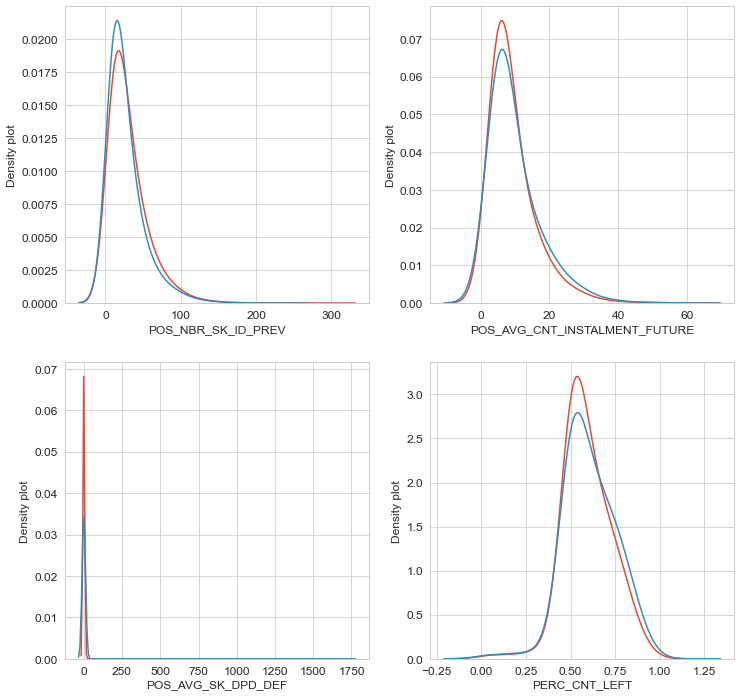

In [13]:
df = POS_appli
cols = [
    'POS_NBR_SK_ID_PREV',
    'POS_AVG_CNT_INSTALMENT_FUTURE',
    'POS_AVG_SK_DPD_DEF',
    'PERC_CNT_LEFT'
]
plot_histogram(df, cols)

## DF credit_card_balance

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.

(Or Monthly balance of client's previous credit card loans in Home Credit)

### DF credit_appli

In [14]:
credit = pd.read_csv('credit_card_balance.csv')
credit_1 = credit.copy()
credit_1['NAME_CONTRACT_STATUS'].value_counts(normalize = True)*100

Active           96.305613
Completed         3.356967
Signed            0.287945
Demand            0.035544
Sent proposal     0.013358
Refused           0.000443
Approved          0.000130
Name: NAME_CONTRACT_STATUS, dtype: float64

In [15]:
credit_1_groupby = credit_1.groupby('SK_ID_CURR').agg(
    CR_NBR_SK_ID_PREV = ('SK_ID_PREV', 'count'),
    CR_AVG_AMT_PAYMENT_TOTAL = ('AMT_PAYMENT_TOTAL_CURRENT', 'mean'),
    CR_AVG_SK_DPD_DEF = ('AMT_TOTAL_RECEIVABLE', 'mean'),
    CR_SUM_CNT_INSTALMENT_MATURE = ('CNT_INSTALMENT_MATURE_CUM', 'sum')
)

# merge application_1 and install_1_groupby by common indentifial number 
credit_appli = application_1.merge(credit_1_groupby, how="inner", on="SK_ID_CURR")
credit_appli.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CR_NBR_SK_ID_PREV,CR_AVG_AMT_PAYMENT_TOTAL,CR_AVG_SK_DPD_DEF,CR_SUM_CNT_INSTALMENT_MATURE
0,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,6,0.000000,0.000000,0.0
1,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0.0,0.0,0.0,0.0,0.0,1.0,74,4520.067568,54433.179122,1881.0
2,100021,0,Revolving loans,F,N,Y,1,81000.0,270000.0,13500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,17,0.000000,0.000000,0.0
3,100023,0,Cash loans,F,N,Y,1,90000.0,544491.0,17563.5,...,0.0,0.0,0.0,0.0,0.0,2.0,8,0.000000,0.000000,0.0
4,100036,0,Cash loans,F,N,Y,0,112500.0,512064.0,25033.5,...,0.0,0.0,0.0,0.0,2.0,5.0,12,0.000000,0.000000,0.0


### Relation between features and TARGET

Correlation between CR_NBR_SK_ID_PREV and TARGET is:
 -0.06048068004751954
Median value for non default loan = 22.0
Median value for default loan = 16.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between CR_AVG_AMT_PAYMENT_TOTAL and TARGET is:
 0.022665094304777346
Median value for non default loan = 3906.818181818182
Median value for default loan = 5986.69125


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between CR_AVG_SK_DPD_DEF and TARGET is:
 0.08648989773622669
Median value for non default loan = 23721.976436170215
Median value for default loan = 61825.73909817982


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between CR_SUM_CNT_INSTALMENT_MATURE and TARGET is:
 -0.042363170409796064
Median value for non default loan = 52.0
Median value for default loan = 45.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

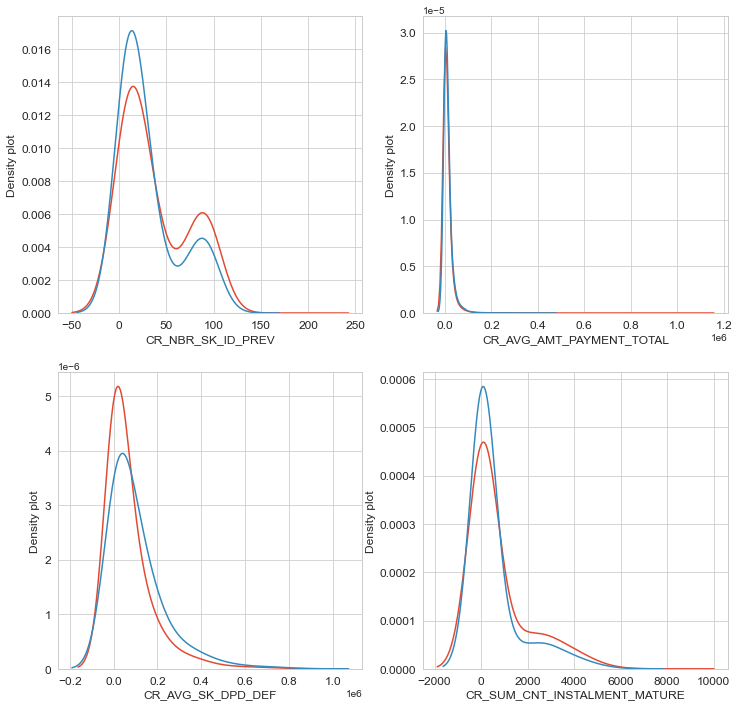

In [16]:
df = credit_appli
cols = [
    'CR_NBR_SK_ID_PREV',
    'CR_AVG_AMT_PAYMENT_TOTAL',
    'CR_AVG_SK_DPD_DEF',
    'CR_SUM_CNT_INSTALMENT_MATURE']
plot_histogram(df, cols)

## Comment Summary

While bureau_balance dataframe contains all information about monthly balances of previous credits in other Credit Bureaus (on the perspective of credit lenders) which may not much relate with the default rate in current applications in objective credit institution, so I decide to not consider this dataframe.

In installments_payments, POS_CASH_balance and credit_card_balance dataframe, in general, previous applications status are most in active (accounted for more than 90%) and the number of refused or canceled applications are negligeably small (under 1%). Furthermore, the correlation coefficients is extremely weak among TARGET and other features; and there are almost no noticeable differences in the distributions in each group of default and non-default loans.

Therefore, we do not use these dataframe and focus on study the main dataframe of application_train/test, previous_application and bureau.

# DF Application_train

## TARGET analyse

In [17]:
application_1['AGE_BIRTH'] = application_1['DAYS_BIRTH']/-365
application_1['YEAR_EMPLOYED'] = application_1['DAYS_EMPLOYED']/-365
count1 = application_1.groupby(['TARGET'])['SK_ID_CURR'].count()   
count1

TARGET
0    282686
1     24825
Name: SK_ID_CURR, dtype: int64

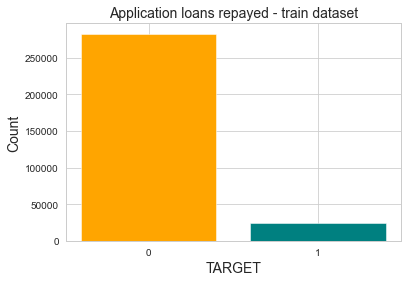

In [18]:
import matplotlib.pyplot as plt
   
TARGET = ['0', '1']
Count = [count1[0], count1[1]]

New_Colors = ['orange','teal']
plt.bar(TARGET, Count, color=New_Colors)
plt.title('Application loans repayed - train dataset', fontsize=14)
plt.xlabel('TARGET', fontsize=14)
plt.ylabel('Count', fontsize=14)
#plt.set_xticklabels(0, 1)
plt.grid(True)
plt.show()

## Function plots barchart for categorical variables

In [19]:
def plot_freq(df_, feature, horizontal_layout=True, label_rotation=False):
    temp = (df_[df_[feature] != 'NaN']).groupby([feature]).count()
    temp.reset_index(inplace = True) 
    temp.rename(columns = {'SK_ID_CURR':'Nbr_contracts'}, inplace = True)
    temp = temp[[feature,'Nbr_contracts','TARGET']]
    
    # Calculate the percentage of TARGET = 1 per category value
    df_per = (df_[df_[feature] != 'NaN']).groupby([feature]).mean()
    df_per.rename(columns = {'TARGET':'avg(TARGET)'}, inplace = True)
    df_per.reset_index(inplace = True) 
    df_per = df_per[['avg(TARGET)', feature]] 
    
    # Plot
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,8))
        plt.subplots_adjust(hspace=0.7)
    
    s = sns.barplot(ax=ax1, x = feature, y="Nbr_contracts",data=temp)
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    s = sns.barplot(ax=ax2, x = feature, y='avg(TARGET)',data=df_per)
    
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
        
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

## Categorical variables

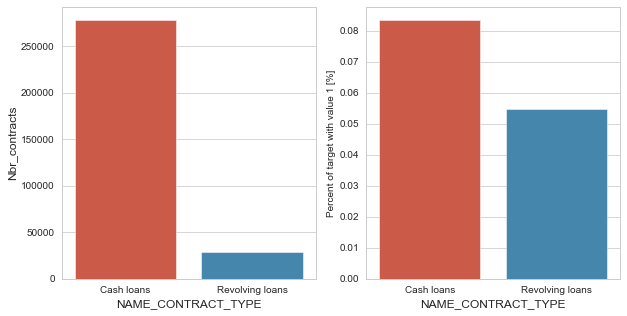

In [20]:
plot_freq(application_1, 'NAME_CONTRACT_TYPE')

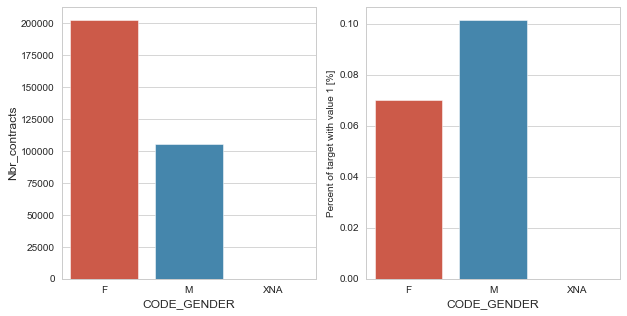

In [21]:
plot_freq(application_1, 'CODE_GENDER')

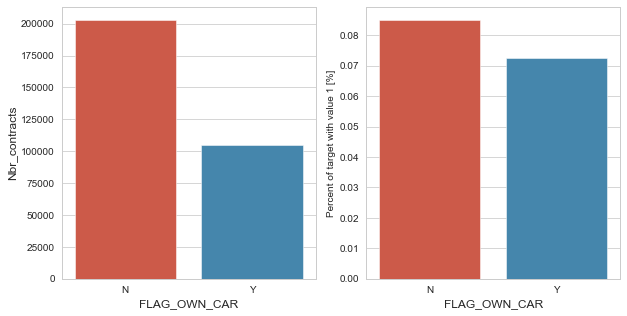

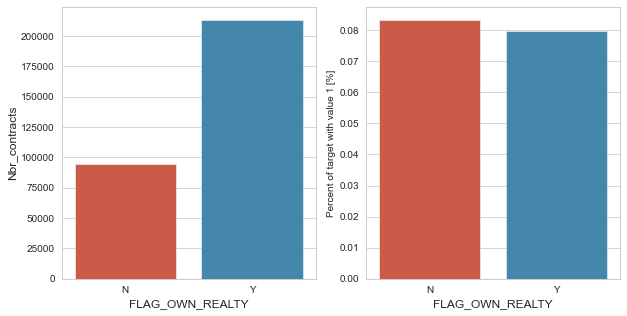

In [22]:
plot_freq(application_1, 'FLAG_OWN_CAR')
plot_freq(application_1, 'FLAG_OWN_REALTY')

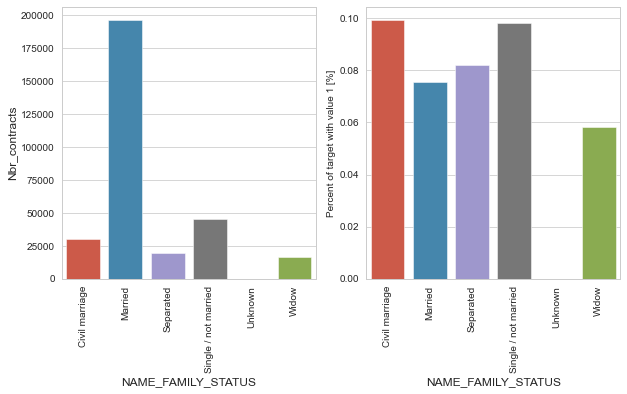

In [23]:
plot_freq(application_1, 'NAME_FAMILY_STATUS', True, True)

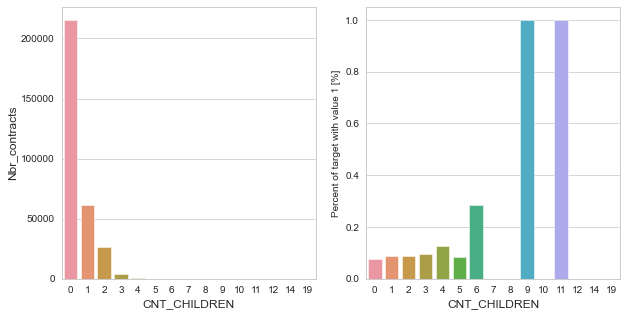

In [24]:
plot_freq(application_1, 'CNT_CHILDREN')

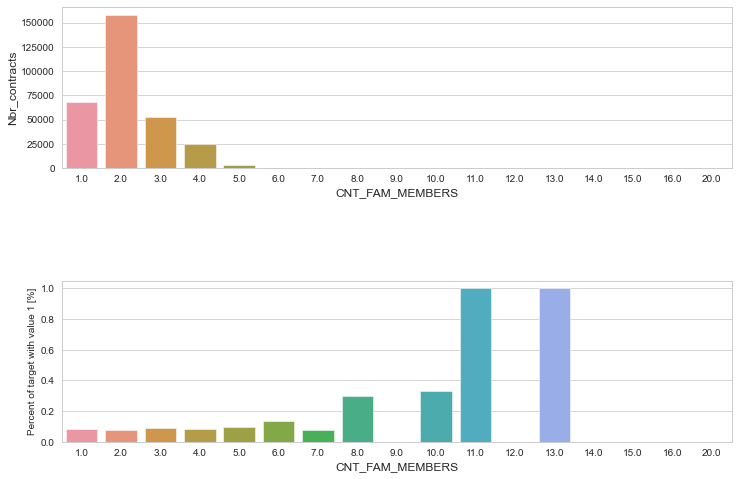

In [25]:
plot_freq(application_1, 'CNT_FAM_MEMBERS', False, False)

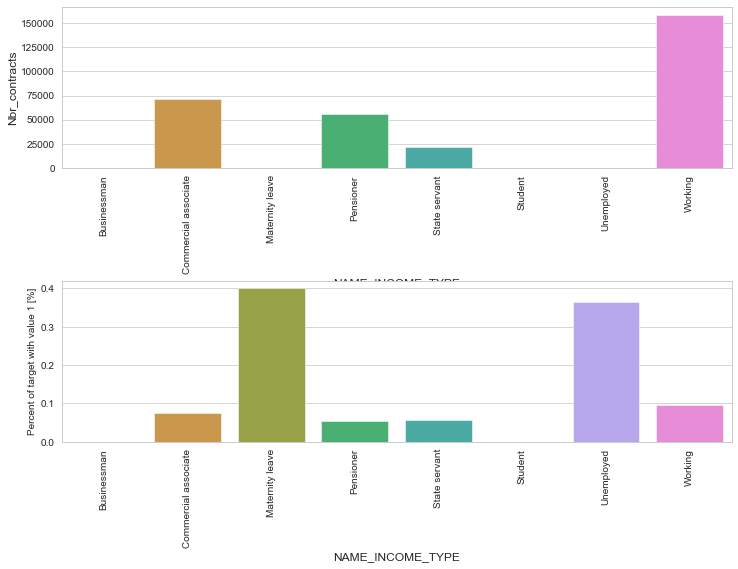

In [26]:
plot_freq(application_1, 'NAME_INCOME_TYPE', False, True)

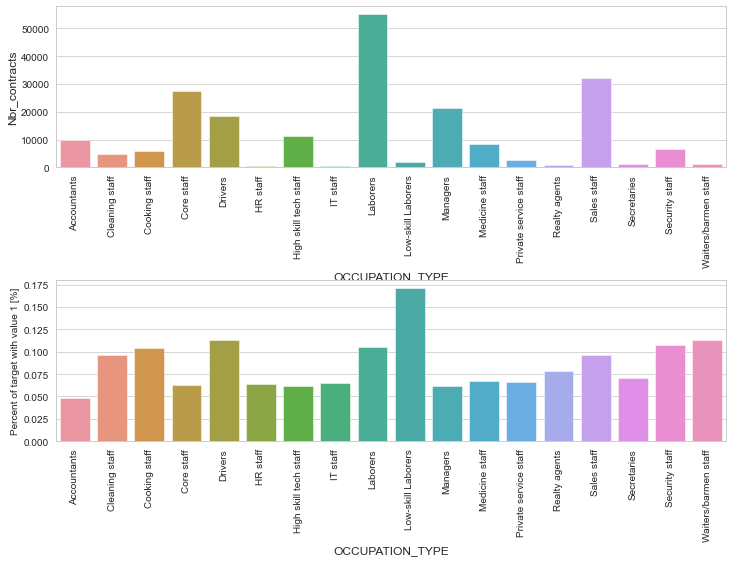

In [27]:
plot_freq(application_1, 'OCCUPATION_TYPE',False, True)

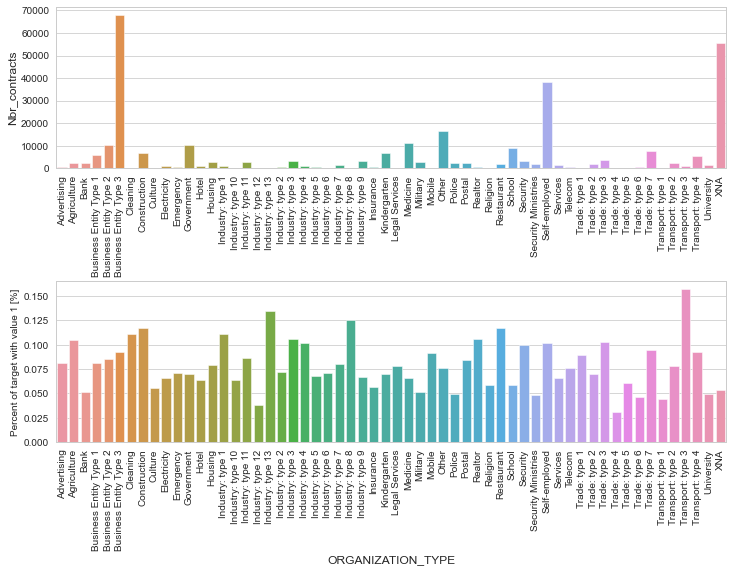

In [28]:
plot_freq(application_1, 'ORGANIZATION_TYPE',False, True)

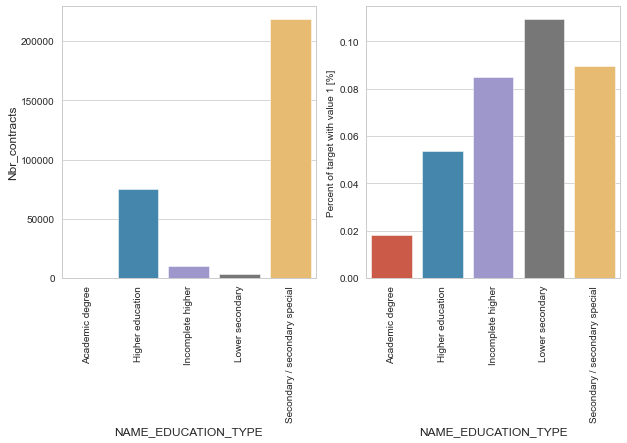

In [29]:
plot_freq(application_1,'NAME_EDUCATION_TYPE',True, True)

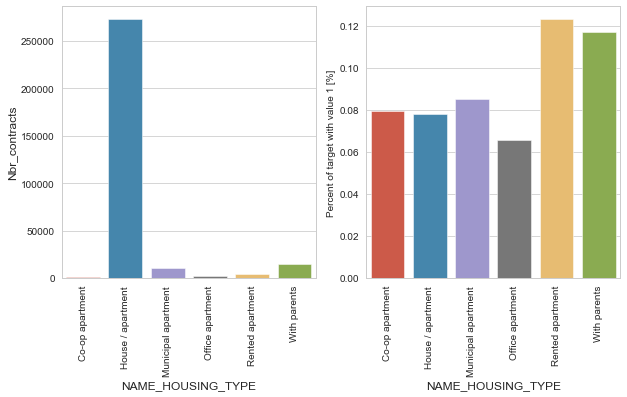

In [30]:
plot_freq(application_1,'NAME_HOUSING_TYPE',True, True)

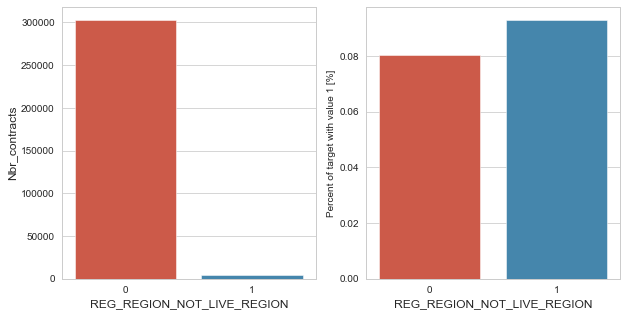

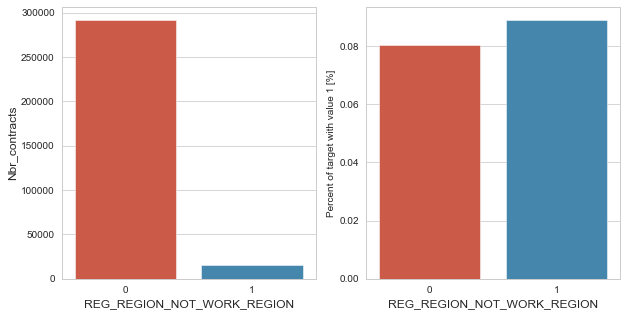

In [31]:
plot_freq(application_1,'REG_REGION_NOT_LIVE_REGION')
plot_freq(application_1,'REG_REGION_NOT_WORK_REGION')

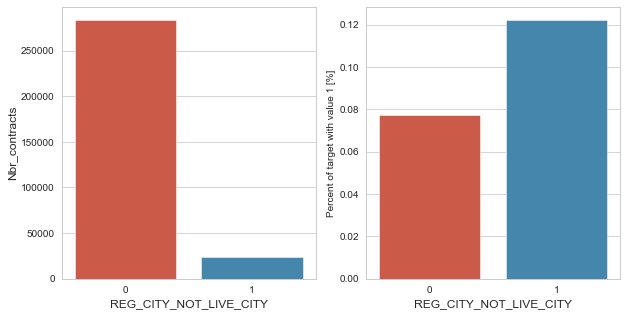

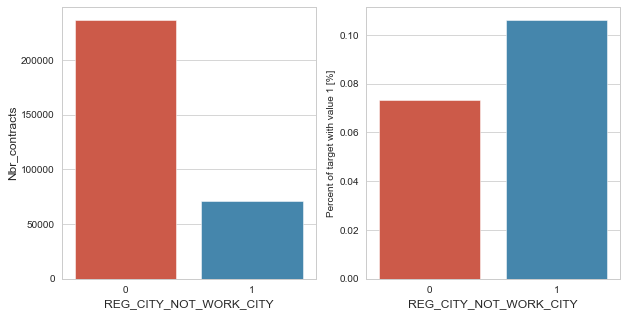

In [32]:
plot_freq(application_1,'REG_CITY_NOT_LIVE_CITY')
plot_freq(application_1,'REG_CITY_NOT_WORK_CITY')

## Function plots distribution for numeric variables

In [33]:
def plot_dist(df, feature,color):
    plt.figure(figsize=(10,6))
    fi = sns.distplot(df[feature].dropna(), color = color, kde=True,bins=100)
    return fi

## Numeric variables

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Density'>

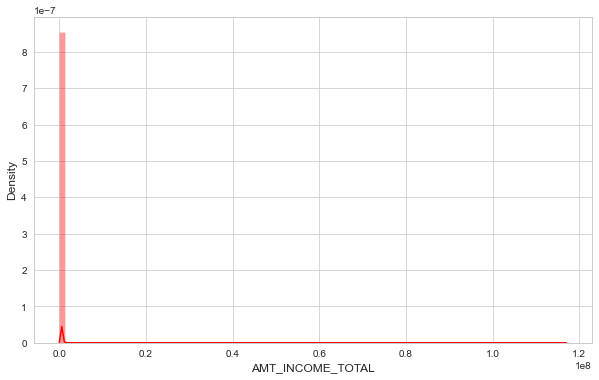

In [34]:
plot_dist(application_1,'AMT_INCOME_TOTAL', 'red')

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AMT_CREDIT', ylabel='Density'>

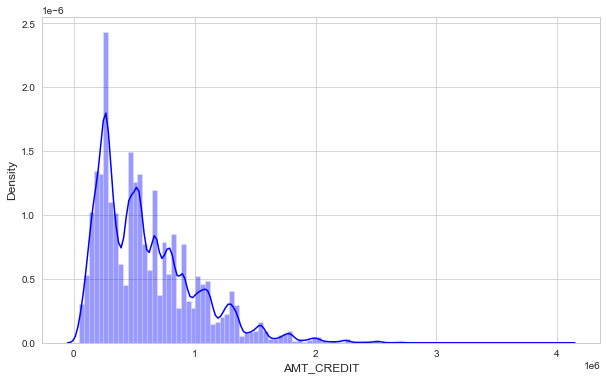

In [35]:
plot_dist(application_1,'AMT_CREDIT','blue')

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AMT_ANNUITY', ylabel='Density'>

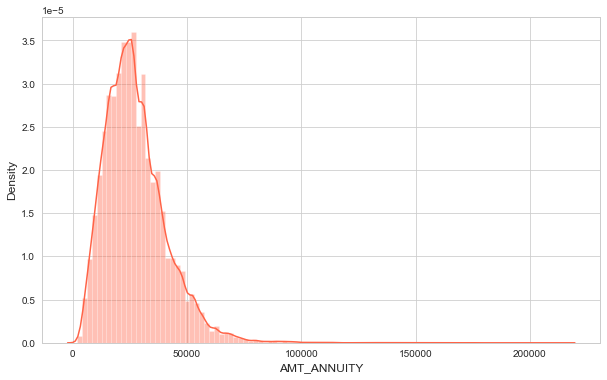

In [36]:
plot_dist(df,'AMT_ANNUITY','tomato')

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AMT_GOODS_PRICE', ylabel='Density'>

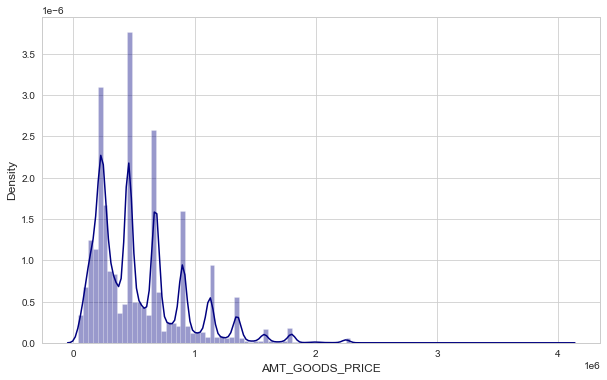

In [37]:
plot_dist(application_1,'AMT_GOODS_PRICE','navy')

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='AGE_BIRTH', ylabel='Density'>

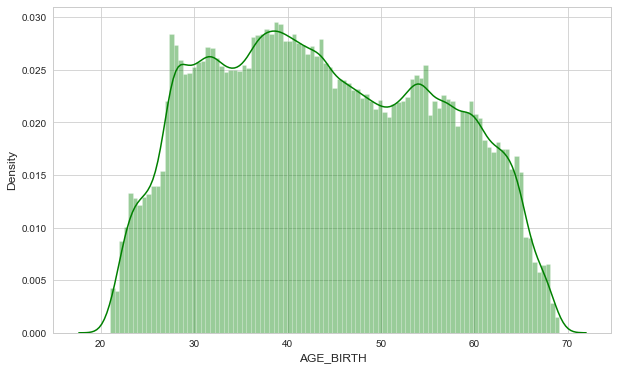

In [38]:
plot_dist(application_1,'AGE_BIRTH','green')

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='YEAR_EMPLOYED', ylabel='Density'>

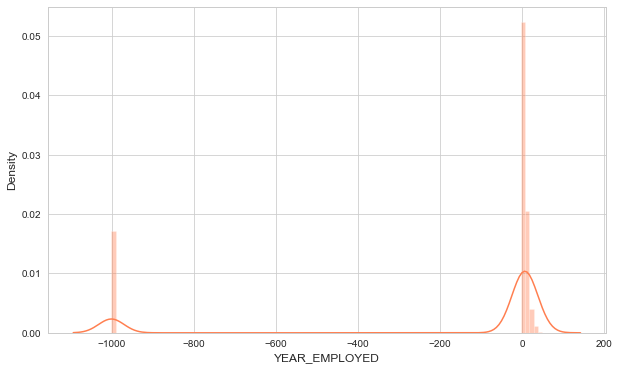

In [39]:
plot_dist(application_1,'YEAR_EMPLOYED','coral')

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DAYS_REGISTRATION', ylabel='Density'>

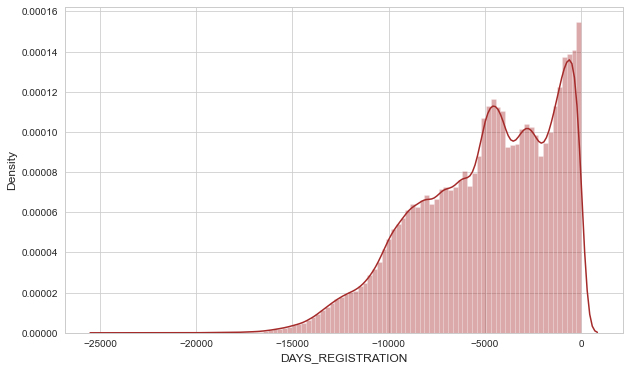

In [40]:
plot_dist(application_1,'DAYS_REGISTRATION','brown')

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DAYS_LAST_PHONE_CHANGE', ylabel='Density'>

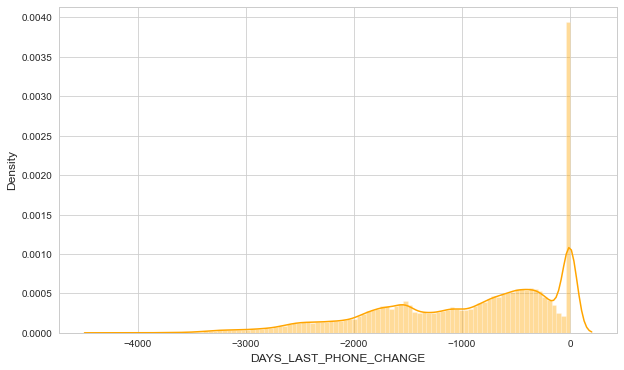

In [41]:
plot_dist(application_1,'DAYS_LAST_PHONE_CHANGE','orange')

## Relation between numeric features and TARGET

Correlation between AMT_ANNUITY and TARGET is:
 -0.01281656151541363
Median value for non default loan = 24876.0
Median value for default loan = 25263.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between AMT_CREDIT and TARGET is:
 -0.030369286461429692
Median value for non default loan = 517788.0
Median value for default loan = 497520.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between AMT_GOODS_PRICE and TARGET is:
 -0.039645281169544196
Median value for non default loan = 450000.0
Median value for default loan = 450000.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between YEAR_EMPLOYED and TARGET is:
 0.044931662657738555
Median value for non default loan = 3.3835616438356166
Median value for default loan = 2.8328767123287673


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between DAYS_REGISTRATION and TARGET is:
 0.04197486283141706
Median value for non default loan = -4544.0
Median value for default loan = -4056.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between AGE_BIRTH and TARGET is:
 -0.07823930830982696
Median value for non default loan = 43.4986301369863
Median value for default loan = 39.12876712328767


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between EXT_SOURCE_1 and TARGET is:
 -0.15531712606394843
Median value for non default loan = 0.5174515531911259
Median value for default loan = 0.36167542779464734


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between EXT_SOURCE_2 and TARGET is:
 -0.16047167160520945
Median value for non default loan = 0.5739046869026359
Median value for default loan = 0.4403806303763837


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between EXT_SOURCE_3 and TARGET is:
 -0.17891869762837181
Median value for non default loan = 0.5460231970049609
Median value for default loan = 0.3791004853998145


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between DAYS_LAST_PHONE_CHANGE and TARGET is:
 0.05521848351345976
Median value for non default loan = -776.0
Median value for default loan = -594.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

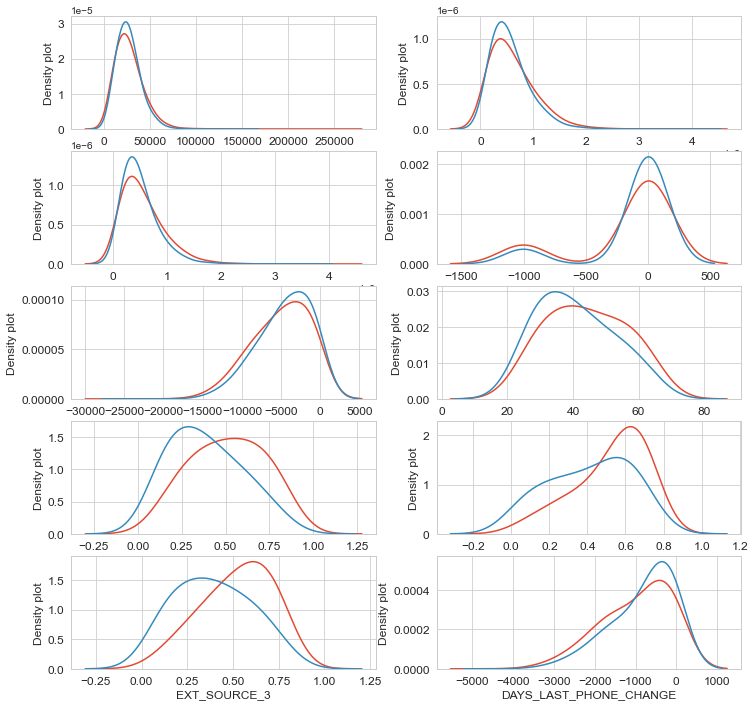

In [42]:
var = [
    'AMT_ANNUITY',
    'AMT_CREDIT',
    'AMT_GOODS_PRICE',
    'YEAR_EMPLOYED', 
    'DAYS_REGISTRATION',
    'AGE_BIRTH',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_LAST_PHONE_CHANGE'
]
plot_histogram(application_1, var)

# DF Bureau

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

## DF bureau_appli

In [43]:
bureau = pd.read_csv('bureau.csv')
cols = bureau.columns
df_br = pd.DataFrame(bureau, columns = cols)
df_br = df_br.add_prefix('BUREAU_')
df_br.rename(columns = {'BUREAU_SK_ID_CURR':'SK_ID_CURR'}, inplace = True)

In [44]:
df_br.columns

Index(['SK_ID_CURR', 'BUREAU_SK_ID_BUREAU', 'BUREAU_CREDIT_ACTIVE',
       'BUREAU_CREDIT_CURRENCY', 'BUREAU_DAYS_CREDIT',
       'BUREAU_CREDIT_DAY_OVERDUE', 'BUREAU_DAYS_CREDIT_ENDDATE',
       'BUREAU_DAYS_ENDDATE_FACT', 'BUREAU_AMT_CREDIT_MAX_OVERDUE',
       'BUREAU_CNT_CREDIT_PROLONG', 'BUREAU_AMT_CREDIT_SUM',
       'BUREAU_AMT_CREDIT_SUM_DEBT', 'BUREAU_AMT_CREDIT_SUM_LIMIT',
       'BUREAU_AMT_CREDIT_SUM_OVERDUE', 'BUREAU_CREDIT_TYPE',
       'BUREAU_DAYS_CREDIT_UPDATE', 'BUREAU_AMT_ANNUITY'],
      dtype='object')

In [45]:
bureau_appli = application_1.merge(df_br, how="inner", on="SK_ID_CURR")

## Categorical variables

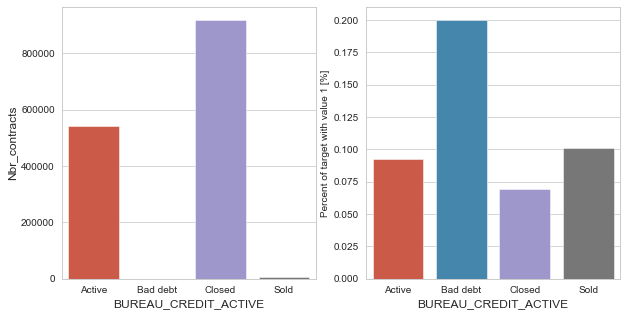

In [46]:
plot_freq(bureau_appli, 'BUREAU_CREDIT_ACTIVE')

Most of the credits registered at the Credit Bureau are in the status Closed (~900K). On the second place are the Active credits ( a bit under 600K). Sold and Bad debt are just a few.

In the same time, as percent having TARGET = 1 from total number per category, clients with credits registered to the Credit Bureau with Bad debt have 20% default on the currrent applications.

Clients with credits Sold, Active and Closed have percent of TARGET == 1 (default credit) equal or less than 10% (10% being the rate overall). The smallest rate of default credit have the clients with credits registered at the Credit Bureau with Closed credits.

That means the former registered credit history (as registered at Credit Bureau) is a strong predictor for the default credit, since the percent of applications defaulting with a history of Bad debt is twice as large as for Sold or Active and almost three times larger as for Closed.


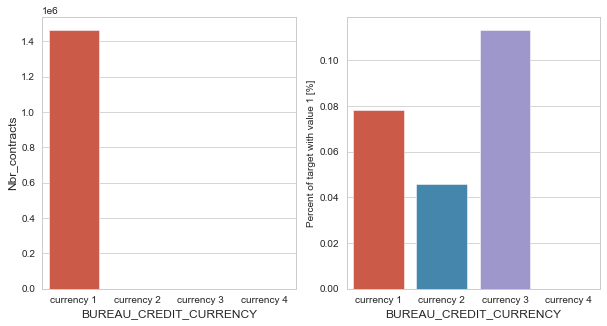

In [47]:
plot_freq(bureau_appli, 'BUREAU_CREDIT_CURRENCY')

Credits are provided mostly in currency_1.

Depending on the currency, the percent of clients defaulting is quite different. Highest with currency_3, then currency_1 and currency_2, the percent of clients defaulting is 11%, 8% and 5%, respectively. Percent of defaulting applications for clients that have credits registered with currency_4 is close to 0.


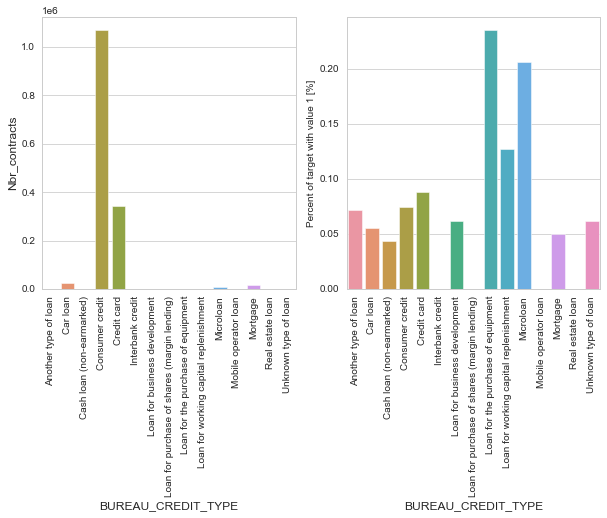

In [48]:
plot_freq(bureau_appli, 'BUREAU_CREDIT_TYPE', True, True)

Majority of historical credits registered at the Credit Bureau are Consumer credit and Credit card. Smaller number of credits are Car loan, Mortgage and Microloan.

Several features should be taken notes here is that:

    Loan for the purchase of equipment - with over 20% current credits defaults
    Microloan - with over 20% current credits defaults
    Loan for working capital replenishement - with over 12% current credits defaults.



## Numeric features

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='BUREAU_DAYS_CREDIT', ylabel='Density'>

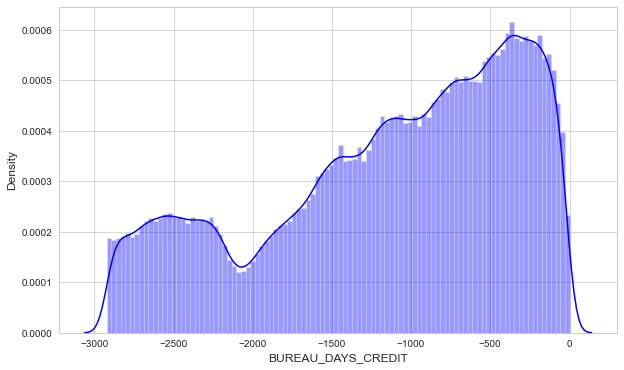

In [49]:
plot_dist(bureau_appli, 'BUREAU_DAYS_CREDIT', 'blue')

The credit duration (in days) is ranging between less than 3000 days (with a local sadle around 2000 days) and with a increasing frequence for shorter number of days - and with a peak around 300 days (or less than one year). Noted that values of 0 comprised the missing data.

<AxesSubplot:ylabel='Frequency'>

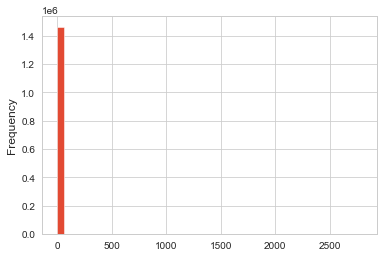

In [50]:
bureau_appli[('BUREAU_CREDIT_DAY_OVERDUE')].plot.hist(bins = 50)

Most of the credits have 0 or close to 0 days overdue. The maximum number of credit days overdue is ~3000 days.

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='BUREAU_AMT_CREDIT_SUM', ylabel='Density'>

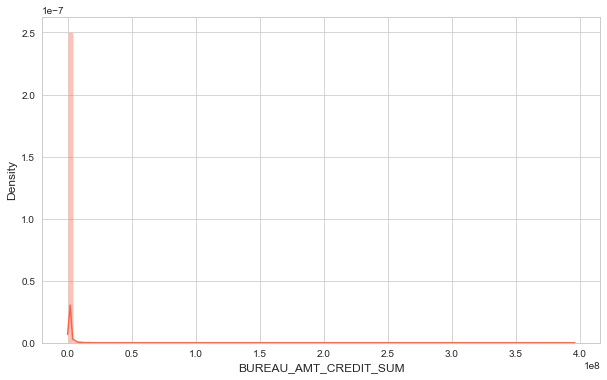

In [51]:
plot_dist(bureau_appli,'BUREAU_AMT_CREDIT_SUM', 'tomato')

The distribution of the BUREAU_AMT_CREDIT_SUM shows a concentration of the credits for the lower credit sum range. Let's remove the outliers so that we can see better the distribution around 0.

We can observe that the distribution function shows several peaks and the maximum concentration of the values is around 20,000 but we also see several other peaks at higher values.


## Relation between numeric features and TARGET

Correlation between BUREAU_DAYS_CREDIT and TARGET is:
 0.06155579551159131
Median value for non default loan = -1004.0
Median value for default loan = -764.5


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between BUREAU_CREDIT_DAY_OVERDUE and TARGET is:
 0.0026518656381426878
Median value for non default loan = 0.0
Median value for default loan = 0.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between BUREAU_AMT_CREDIT_SUM and TARGET is:
 -0.01060627676227341
Median value for non default loan = 125206.4025
Median value for default loan = 119880.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between BUREAU_AMT_CREDIT_SUM_LIMIT and TARGET is:
 -0.005990004180340889
Median value for non default loan = 0.0
Median value for default loan = 0.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

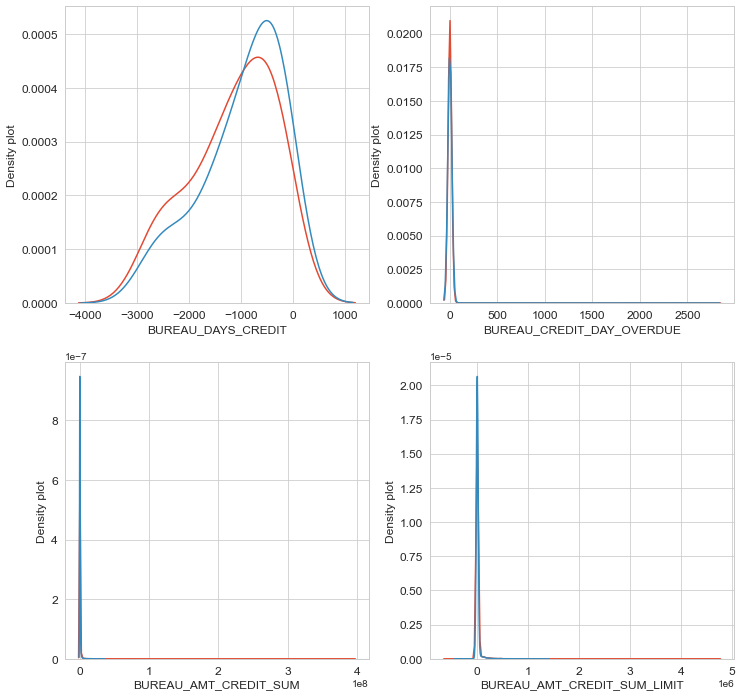

In [52]:
var = [
    'BUREAU_DAYS_CREDIT',
    'BUREAU_CREDIT_DAY_OVERDUE',
    'BUREAU_AMT_CREDIT_SUM', 
    'BUREAU_AMT_CREDIT_SUM_LIMIT'
]
plot_histogram(bureau_appli, var)

# DF Previous_application

All previous applications for Home Credit loans of clients who have loans in our sample.

## Create DF prev_appli

In [53]:
previous = pd.read_csv('previous_application.csv')
cols = previous.columns
df_pr = pd.DataFrame(previous, columns = cols)
df_pr = df_pr.add_prefix('PREV_')
df_pr.rename(columns = {'PREV_SK_ID_CURR':'SK_ID_CURR'}, inplace = True)

In [54]:
prev_appli = application_1.merge(df_pr, how="inner", on="SK_ID_CURR")

## Categorical variables

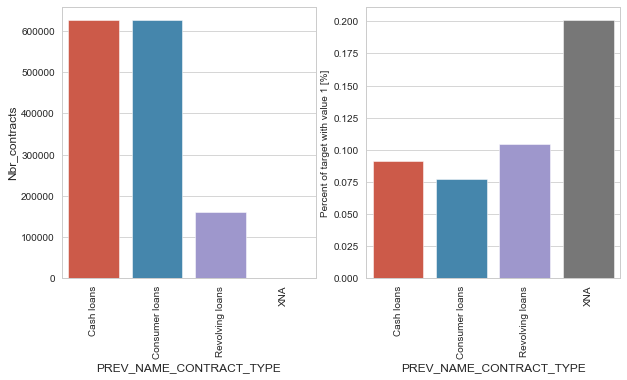

In [55]:
plot_freq(prev_appli, 'PREV_NAME_CONTRACT_TYPE', True, True)

There are three types of contract in the previous application data: Cash loans, Consumer loans, Revolving loans. Cash loans and Consumer loans are almost the same number (~600K) whilst Revolving loans are ~150K.

The percent of defauls loans for clients with previous applications is different for the type of previous applications contracts, decreasing from ~10% for Revolving loans, then ~ 9.5% for Cash loans and ~8% for Consumer loans.


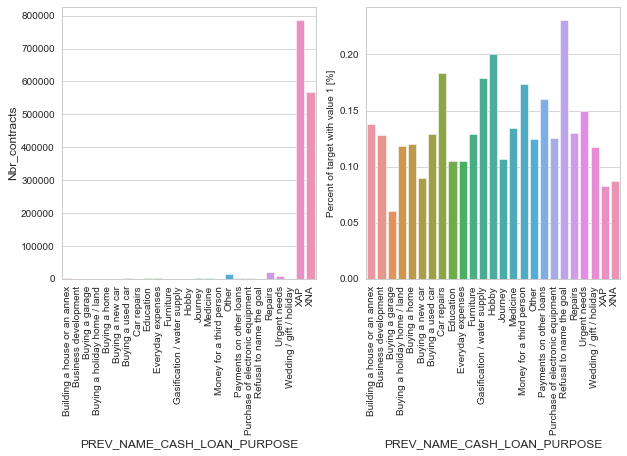

In [56]:
plot_freq(prev_appli, 'PREV_NAME_CASH_LOAN_PURPOSE', True, True)

Besides not identifed/not available categories, Repairs, Other, Urgent needs, Buying a used car, Building a house or an annex accounts for the largest number of contracts.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history are previous applications for cash loans for Refusal to name the goal ~23% (which makes a lot of sense), Hobby (20%), Car repairs (~18%).


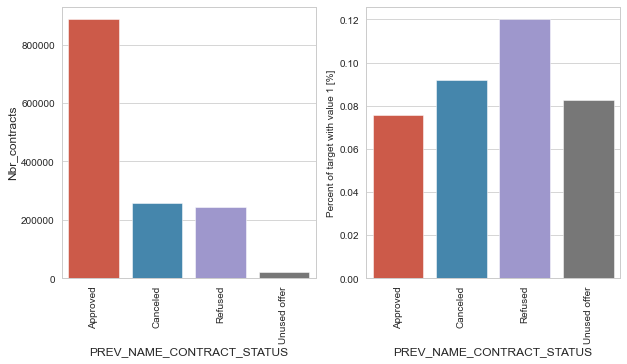

In [57]:
plot_freq(prev_appli, 'PREV_NAME_CONTRACT_STATUS', True, True)

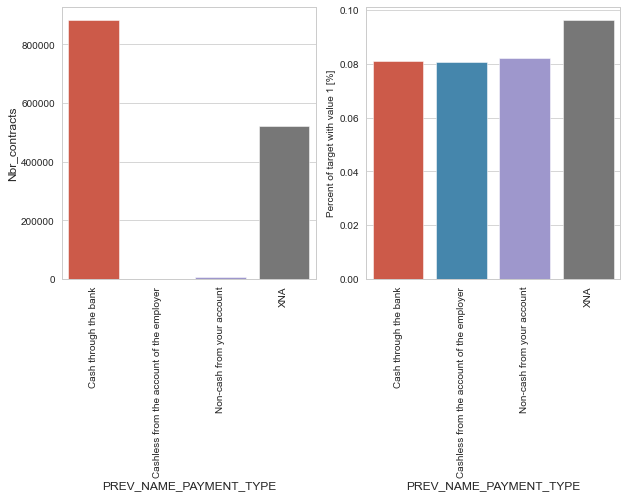

In [58]:
plot_freq(prev_appli, 'PREV_NAME_PAYMENT_TYPE', True, True)

Most previous applications contract statuses are Approved (~850K), Canceled and Refused (~240K). There are only ~20K in status Unused offer.

In terms of percent of defaults for current applications in the sample, clients with history of previous applications have largest percents of defaults when in their history contract statuses are Refused (12%), followed by Canceled (9%), Unused offer (~8%) and Approved (lowest percent of defaults in current applictions, with less than 8%).


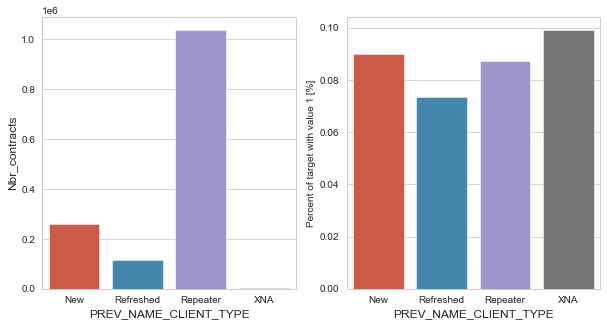

In [59]:
plot_freq(prev_appli, 'PREV_NAME_CLIENT_TYPE')

Most of the previous applications were paid with Cash through the bank ( ~ 850K). Payments using Non-cash from your account or Cashless from the account of the employer are much rare. These three types of payments in previous applications results in almost the same percent of defaults for current clients (~8% each).

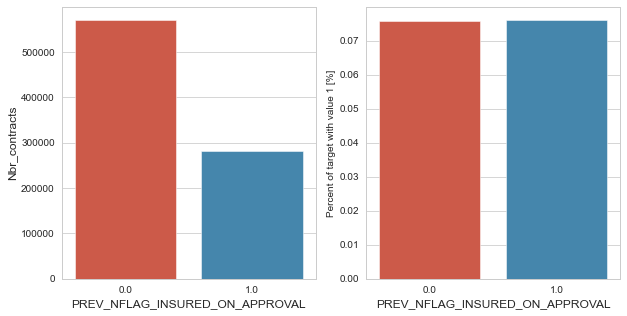

In [60]:
plot_freq(prev_appli, 'PREV_NFLAG_INSURED_ON_APPROVAL')

Most of the previous applications have client type Repeater (~1M), just over 200K are New and ~100K are Refreshed.

In terms of default percent for current applications of clients with history of previous applications, current clients with previous applications have values of percent of defaults ranging from from 8.5%, 8.25% and 7% corresponding to client types in the past New, Repeater and Refreshed, respectivelly.


## Numeric variables

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PREV_AMT_ANNUITY', ylabel='Density'>

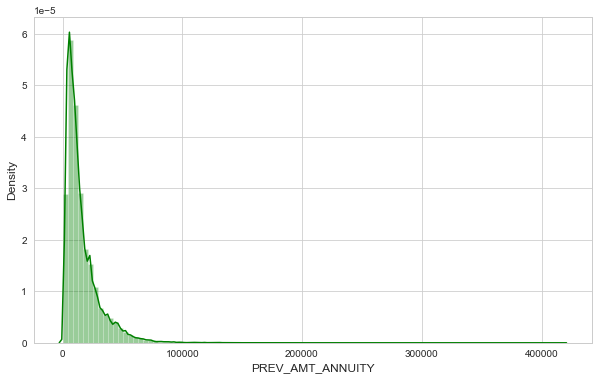

In [61]:
plot_dist(prev_appli, 'PREV_AMT_ANNUITY', 'green')

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PREV_AMT_APPLICATION', ylabel='Density'>

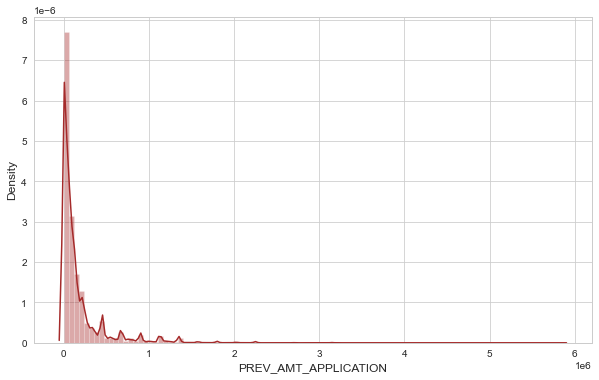

In [62]:
plot_dist(prev_appli, 'PREV_AMT_APPLICATION', 'brown')

C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PREV_AMT_CREDIT', ylabel='Density'>

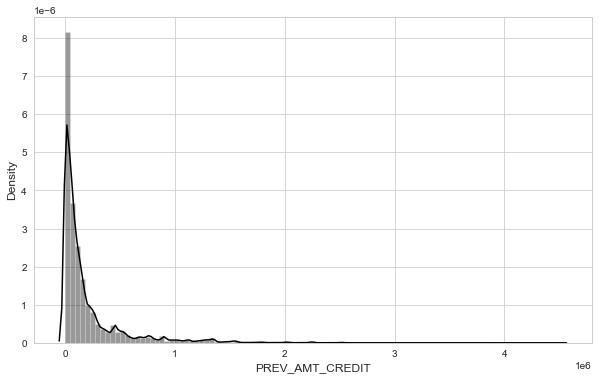

In [63]:
plot_dist(prev_appli, 'PREV_AMT_CREDIT', 'black')

## Relation between numeric features and TARGET

Correlation between PREV_AMT_ANNUITY and TARGET is:
 -0.014922495270221312
Median value for non default loan = 11245.5
Median value for default loan = 10911.375


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between PREV_AMT_APPLICATION and TARGET is:
 -0.005582767460686742
Median value for non default loan = 71662.5
Median value for default loan = 66555.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between PREV_AMT_CREDIT and TARGET is:
 -0.002350348956335931
Median value for non default loan = 80968.5
Median value for default loan = 74700.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between PREV_DAYS_FIRST_DUE and TARGET is:
 -0.006650752638591397
Median value for non default loan = -832.0
Median value for default loan = -748.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between PREV_DAYS_LAST_DUE and TARGET is:
 0.017522023261012983
Median value for non default loan = -542.0
Median value for default loan = -452.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


Correlation between PREV_DAYS_TERMINATION and TARGET is:
 0.01698148046547578
Median value for non default loan = -501.0
Median value for default loan = -416.0


C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
C:\Users\HO_ANT\Anaconda3\lib\site-packages\seaborn\distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

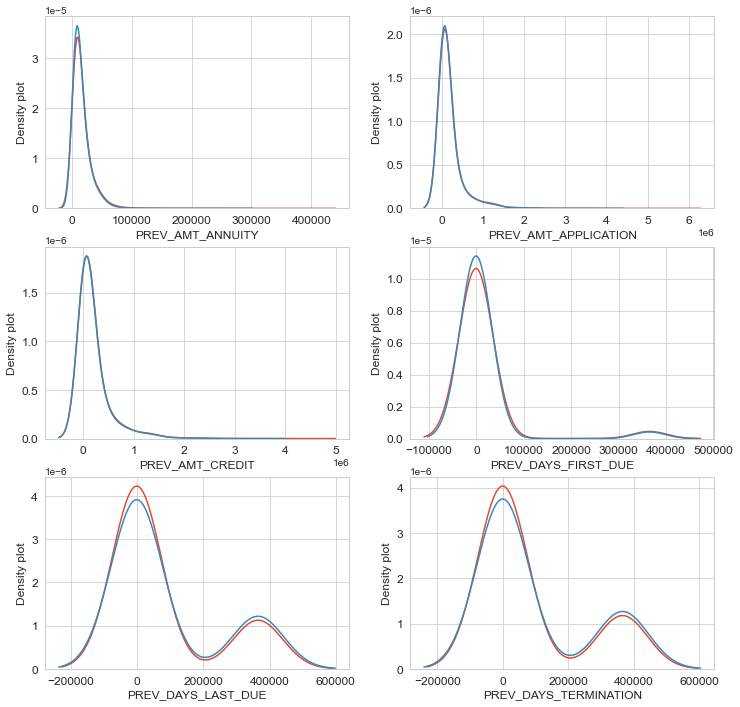

In [64]:
var = [
    'PREV_AMT_ANNUITY',
    'PREV_AMT_APPLICATION',
    'PREV_AMT_CREDIT',
    'PREV_DAYS_FIRST_DUE',
    'PREV_DAYS_LAST_DUE',
    'PREV_DAYS_TERMINATION'
]
plot_histogram(prev_appli, var)

# Merging final DataFrame

In [72]:
filename = [
    'application_train',
    'bureau',
    'previous_application'
]

cols_application_train = [
    'SK_ID_CURR',
     'TARGET',
     'NAME_CONTRACT_TYPE',
     'CODE_GENDER',
     'FLAG_OWN_CAR',
     'FLAG_OWN_REALTY',
     'CNT_CHILDREN',
     'AMT_INCOME_TOTAL',
     'AMT_CREDIT',
     'AMT_ANNUITY',
     'AMT_GOODS_PRICE',
     'NAME_INCOME_TYPE',
     'NAME_EDUCATION_TYPE',
     'NAME_FAMILY_STATUS',
     'NAME_HOUSING_TYPE',
     'DAYS_BIRTH',
     'DAYS_EMPLOYED',
     'DAYS_REGISTRATION',
     'OCCUPATION_TYPE',
     'CNT_FAM_MEMBERS',
     'REG_REGION_NOT_LIVE_REGION',
     'REG_REGION_NOT_WORK_REGION',
     'REG_CITY_NOT_LIVE_CITY',
     'REG_CITY_NOT_WORK_CITY',
     'ORGANIZATION_TYPE',
     'EXT_SOURCE_1',
     'EXT_SOURCE_2',
     'EXT_SOURCE_3',
     'DAYS_LAST_PHONE_CHANGE'
]

cols_bureau = [
    'SK_ID_CURR',
    'SK_ID_BUREAU',
    'CREDIT_ACTIVE',
    'DAYS_CREDIT',
    'DAYS_CREDIT_ENDDATE', 
    'AMT_CREDIT_SUM', 
    'AMT_CREDIT_SUM_OVERDUE', 
    'CREDIT_TYPE'
]

cols_prev = [
    'SK_ID_PREV',
    'SK_ID_CURR', 
    'AMT_APPLICATION', 
    'NAME_CONTRACT_STATUS', 
    'NAME_CLIENT_TYPE',
    'DAYS_LAST_DUE',
    'DAYS_TERMINATION',
    'NFLAG_INSURED_ON_APPROVAL'
]

cols_keep = [cols_application_train, cols_bureau, cols_prev]

In [73]:
appli_final = application_1[cols_application_train]
bureau_final = bureau[cols_bureau]
previous_final = previous[cols_prev]

In [74]:
df_train1 = appli_final.merge(bureau_final, how="left", on="SK_ID_CURR")
df_train = df_train1.merge(previous_final, how="left", on="SK_ID_CURR")
df_train = df_train1.merge(previous_final, how="left", on="SK_ID_CURR")

df_train_final = df_train.dropna()
train_set = df_train_final.sample(n=20000)
df_train_final.to_csv('train_set.csv')